# Talking Data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import time
import random
import tarfile
import zipfile
#import StringIO
from IPython.display import display, Image

from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MeanShift
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score


datadir="./data/TalkingData/"

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

### some function def

In [78]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [85]:
   
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict_proba(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "\nprediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=200,C=.1, n_jobs = -1)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Import data

In [4]:
# load up the data!
app_events = loadData(datadir,'app_events.csv.zip')
app_labels = loadData(datadir,'app_labels.csv.zip')
label_categories = loadData(datadir,'label_categories.csv.zip')

events = loadData(datadir,'events.csv.zip')
events['timestamp']=pd.to_datetime(events['timestamp'])


phone_brand_device_model = loadData(datadir,'phone_brand_device_model.csv.zip')
phone_brand_device_model.drop_duplicates('device_id',keep='first', inplace=True)

gender_age_train = loadData(datadir,'gender_age_train.csv.zip')
#gender_age_test = loadData(datadir,'gender_age_test.csv.zip')




loading: ./data/TalkingData/app_events.csv.zip
Dataset has 32473067 samples with 4 features each.
loading: ./data/TalkingData/app_labels.csv.zip
Dataset has 459943 samples with 2 features each.
loading: ./data/TalkingData/label_categories.csv.zip
Dataset has 930 samples with 2 features each.
loading: ./data/TalkingData/events.csv.zip
Dataset has 3252950 samples with 5 features each.
loading: ./data/TalkingData/phone_brand_device_model.csv.zip
Dataset has 187245 samples with 3 features each.
loading: ./data/TalkingData/gender_age_train.csv.zip
Dataset has 74645 samples with 4 features each.


### Create a location feature, and look at it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 2 columns):
longitude    float64
latitude     float64
dtypes: float64(2)
memory usage: 49.6 MB


None

,longitude,latitude
0,121.38,31.24
1,103.65,30.97
2,106.60,29.70
3,104.27,23.28


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


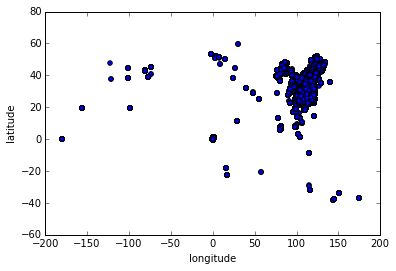

In [5]:
#cluster the locations in the event
display(events.info())
display(events.head(4))

locations=events.drop(['event_id','device_id','timestamp'],1)
display(locations.info())
display(locations.head(4))

locations.plot(kind='scatter',x='longitude',y='latitude')
plt.show()
plt.close()

In [7]:
# get many cluster centers of the data, for a large number of clusters
def kmeansPlusmeanshift(data):
    startingClusterSize=int(len(data)*.0005)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.2).values)
    clusters=k_means.cluster_centers_
    print clusters[:15]

    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)

    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    return final_clusters
    
    
final_clusters=kmeansPlusmeanshift(locations)
print "sample clusters after kmeans:\n ",final_clusters[:15]
    

kmeans.... for 1626 clusters


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local

[[  1.20556120e+02   3.06416871e+01]
 [  1.13655421e-05  -4.58740741e-05]
 [  1.13029334e+02   2.37111096e+01]
 [  1.14478502e+02   3.66083671e+01]
 [  1.04107681e+02   3.06518940e+01]
 [  1.23780713e+02   4.18525426e+01]
 [ -7.71922034e+01   3.88898305e+01]
 [  1.15920389e+02   2.85804805e+01]
 [ -1.80000000e+02  -3.55271368e-15]
 [  8.87810000e+01   4.43070000e+01]
 [  1.17582632e+02   3.70244737e+01]
 [  1.12204109e+02   3.03446264e+01]
 [  1.16406583e+02   3.98258868e+01]
 [  1.08312513e+02   2.28582172e+01]
 [  1.11924194e+02   3.47392163e+01]]

meanshift...
[[  1.14213326e+02   3.16053789e+01]
 [  8.75790264e+01   4.21831175e+01]
 [  6.41952354e-01   6.68692888e-01]
 [  7.99767867e+01   7.94594667e+00]
 [  4.18073333e+00   5.10095778e+01]
 [ -7.73620223e+01   4.24920647e+01]
 [  4.72980653e+01   2.86186319e+01]
 [  1.46460000e+02  -3.67433333e+01]
 [  1.65300000e+01  -2.02550000e+01]
 [  2.49550000e+01   4.12650000e+01]
 [ -1.22320000e+02   4.76400000e+01]
 [  5.73700000e+01  -2.

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local

sample clusters after kmeans:
  [ 8  3  3 19 12  1 14  9  1  5 20 20 13 12  8]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     int32
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 136.5 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,8
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,3
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,3
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,19
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,12
5,6,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,1
6,7,5990807147117726237,2016-05-01 00:15:13,113.73,23.00,14
7,8,1782450055857303792,2016-05-01 00:15:35,113.94,34.70,9
8,9,-2073340001552902943,2016-05-01 00:15:33,0.00,0.00,1
9,10,-8195816569128397698,2016-05-01 00:41:31,119.34,26.04,5


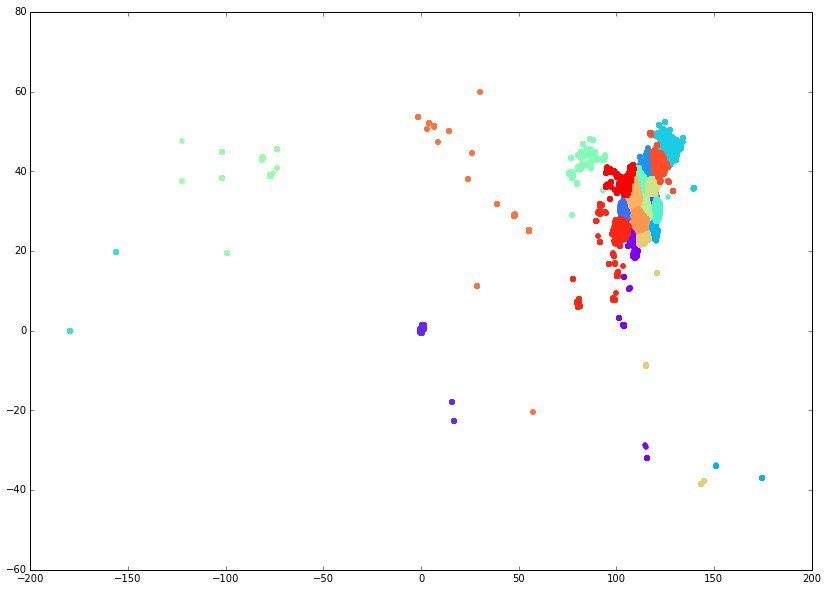

In [8]:
events['location']=final_clusters
display(events.info())
display(events.head(10))

numlocationclusters=len(np.unique(final_clusters))

plt.figure(figsize=(14,10))
colors = cm.rainbow(np.linspace(0, 1, numlocationclusters))

for cluster in range(numlocationclusters):
    plt.scatter(events[events['location']==cluster]['longitude'],
             events[events['location']==cluster]['latitude'],
             color=colors[cluster])
             #color=colors[locations[locations['cluster']==cluster]['cluster']])
        
plt.show()
plt.close()

### Create a time feature

In [9]:

#times=events['timestamp']
display(events.info())
display(events.head(5))

events_timeindex=events.set_index('timestamp')
#display(events_timeindex.info())
#display(events_timeindex.head(5))

events["hour"] = events_timeindex.index.hour
events["day"] = events_timeindex.index.day
print "unique days",events["day"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     int32
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 136.5 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,8
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,3
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,3
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,19
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,12


unique days [ 1 30  2  3  4  5  6  7  8]


### take the new created features into a new setting, leaving the original as it was.

In [10]:
events_featured=events.drop(["timestamp",'longitude','latitude'],1) 
events.drop(["location",'hour','day'],1) 

display(events.sample(frac=0.2).head(5))
display(events_featured.sample(frac=0.2).head(5))
display(events_featured.info())


,event_id,device_id,timestamp,longitude,latitude,location,hour,day
1513837,1513838,-2891958129029224207,2016-05-04 16:18:38,108.90,34.29,15,16,4
401926,401927,7666438183926481871,2016-05-07 02:35:21,0.00,0.00,1,2,7
1766734,1766735,-2203538435354016841,2016-05-07 07:36:33,114.35,36.06,9,7,7
917908,917909,8154483520191499704,2016-05-05 03:24:17,0.00,0.00,1,3,5
3090725,3090726,-2112006630916684299,2016-05-01 08:53:54,106.52,29.51,3,8,1


,event_id,device_id,location,hour,day
2146839,2146840,-8551450802316187249,4,9,1
1775066,1775067,3915082290673137129,4,14,1
1927294,1927295,1056689224530692256,13,9,3
2229871,2229872,-3729853421738413902,5,7,5
1879835,1879836,-7298708666022567305,9,11,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
location     int32
hour         int32
day          int32
dtypes: int32(3), int64(2)
memory usage: 86.9 MB


None

In [11]:
# from https://www.kaggle.com/agavranis/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/code
# Data - Events data
# Bag of apps
print("# Read app events")
#app_events = pd.read_csv(os.path.join(datadir,'app_events.csv'), dtype={'device_id' : np.str})
display(app_events.head(5))
display(app_events.info())
#print(rstr(app_events))




# Read app events


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtypes: int64(4)
memory usage: 991.0 MB


None

In [12]:
# store all the unique app ids
app_id_unique= app_events.app_id.unique()
print len(app_id_unique)
display(app_id_unique[:15])


19237


array([ 5927333115845830913, -5720078949152207372, -1633887856876571208,
        -653184325010919369,  8693964245073640147,  4775896950989639373,
       -8022267440849930066,  9112463267739110219, -3725672010020973973,
        7167114343576723123,   487766649788038994,  7460082553072507347,
         628020936226491308,   701031210314548601, -1758857579862594461])

In [13]:
# remove duplicates(app_id)
app_events= app_events.groupby("event_id")["app_id"].apply(
        lambda x: list(s for s in x))
        #lambda x: list(np.where(app_id_unique==s) for s in x))
app_events.head(5)

event_id
2     [5927333115845830913, -5720078949152207372, -1...
6     [-7377004479023402858, 6284164581582112235, 59...
7     [-5025470775416984603, -5368809411346728624, 2...
9     [-7377004479023402858, -5025470775416984603, -...
16    [-7377004479023402858, 5070413844955847732, -1...
Name: app_id, dtype: object

In [14]:
print("# Read Events")
#events = pd.read_csv(os.path.join(datadir,'events.csv'), dtype={'device_id': np.str})
display(events_featured.head(5))
events_featured["app_id"] = events_featured["event_id"].map(app_events)
events_featured = events_featured.dropna()

events_featured = events_featured[["device_id", "app_id", 'event_id','location', 'hour','day']]
display(events_featured.info())
display(events_featured.head(4))
# 1Gb reduced to 34 Mbevents_featured.head(5)

# Read Events


,event_id,device_id,location,hour,day
0,1,29182687948017175,8,0,1
1,2,-6401643145415154744,3,0,1
2,3,-4833982096941402721,3,0,1
3,4,-6815121365017318426,19,0,1
4,5,-5373797595892518570,12,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 6 columns):
device_id    1488096 non-null int64
app_id       1488096 non-null object
event_id     1488096 non-null int64
location     1488096 non-null int32
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: int32(3), int64(2), object(1)
memory usage: 62.4+ MB


None

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[5927333115845830913, -5720078949152207372, -1...",2,3,0,1
5,1476664663289716375,"[-7377004479023402858, 6284164581582112235, 59...",6,1,0,1
6,5990807147117726237,"[-5025470775416984603, -5368809411346728624, 2...",7,14,0,1
8,-2073340001552902943,"[-7377004479023402858, -5025470775416984603, -...",9,1,0,1


### vectorize the apps:

In [15]:
print app_id_unique[:3]

element=-1633887856876571208

itemindex = np.where(app_id_unique==element)
print "element:",element,"index is:",itemindex,"contains:", app_id_unique[itemindex]




[ 5927333115845830913 -5720078949152207372 -1633887856876571208]
element: -1633887856876571208 index is: (array([2]),) contains: [-1633887856876571208]


In [16]:
events_vectorized_appID=events_featured.app_id.apply(lambda x: list(np.where(app_id_unique==s)[0][0] for s in x))
display(events_vectorized_appID.head(4))


1    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
5    [19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,...
6    [53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...
8    [19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,...
Name: app_id, dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 6 columns):
device_id    1488096 non-null int64
app_id       1488096 non-null object
event_id     1488096 non-null int64
location     1488096 non-null int32
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: int32(3), int64(2), object(1)
memory usage: 62.4+ MB


None

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,3,0,1
5,1476664663289716375,"[19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,...",6,1,0,1
6,5990807147117726237,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...",7,14,0,1
8,-2073340001552902943,"[19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,...",9,1,0,1


In [ ]:
events_featured_Appid_orig=events_featured['app_id']

events_featured['app_id']=events_vectorized_appID

display(events_featured.info())
display(events_featured.head(4))

In [18]:

#events_featured['app_id']=events_featured_Appid_orig

#display(events_featured.info())
display(events_featured.head(4))

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,3,0,1
5,1476664663289716375,"[19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,...",6,1,0,1
6,5990807147117726237,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...",7,14,0,1
8,-2073340001552902943,"[19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,...",9,1,0,1


In [19]:
del app_events

### start merging with the training data

In [20]:
# just events related to devices in training:
display(gender_age_train.info())
display(gender_age_train.head(4))

print ("merging: events_featured")
train_events = gender_age_train.merge(events_featured, how='left', on='device_id')
train_events.drop(['gender','age'],1, inplace=True)
display(train_events.info())
display(train_events.head(4))

print ("merging: phone_brand_device_model")
train_events = train_events.merge(phone_brand_device_model, how='left', on='device_id')
display(train_events.info())
display(train_events.head(4))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
device_id    74645 non-null int64
gender       74645 non-null object
age          74645 non-null int64
group        74645 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


None

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31


merging: events_featured
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 7 columns):
device_id    607730 non-null int64
group        607730 non-null object
app_id       556375 non-null object
event_id     556375 non-null float64
location     556375 non-null float64
hour         556375 non-null float64
day          556375 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 37.1+ MB


None

,device_id,group,app_id,event_id,location,hour,day
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN
2,-8260683887967679142,M32-38,"[2109, 858, 237, 3888, 4083, 2419, 332, 1401, ...",2479656.0,1.0,14.0,1.0
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN


merging: phone_brand_device_model
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 9 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          556375 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
phone_brand     607730 non-null object
device_model    607730 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 46.4+ MB


None

,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN,小米,MI 2
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN,小米,MI 2
2,-8260683887967679142,M32-38,"[2109, 858, 237, 3888, 4083, 2419, 332, 1401, ...",2479656.0,1.0,14.0,1.0,小米,MI 2
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN,小米,红米note



### Label encode the strings!

In [43]:
device_modelLE =  LabelEncoder().fit(train_events['device_model'])
train_events['device_model'] = device_modelLE.transform(train_events['device_model'])

phone_brandLE =  LabelEncoder().fit(train_events['phone_brand'])
train_events['phone_brand'] = phone_brandLE.transform(train_events['phone_brand'])
()

device_idLE =  LabelEncoder().fit(train_events['device_id'])
train_events['device_id'] = device_idLE.transform(train_events['device_id'])
()

display(train_events.info())
display(train_events.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 9 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          556375 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
phone_brand     607730 non-null int64
device_model    607730 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 46.4+ MB


None

,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
0,4656,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
1,25592,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
2,3892,M32-38,"[2109, 858, 237, 3888, 4083, 2419, 332, 1401, ...",2479656.0,1.0,14.0,1.0,47,677
3,17373,M29-31,NaN,NaN,NaN,NaN,NaN,47,1369


### save this version of things for quicker use...
just skip down here after the initial import and functions for quicker access to the training section. note that we aren't keeping around things like the label encoders, etc, as we don't need those at them moment

In [51]:
writeData(train_events,"train_events.csv")

['device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model\n',
 '4656,M32-38,,,,,,47,677\n',
 '25592,M32-38,,,,,,47,677\n',
 '3892,M32-38,"[2109, 858, 237, 3888, 4083, 2419, 332, 1401, 1894, 334, 2423, 6441, 3477, 284, 3452, 1250, 4387, 5753, 3050, 337, 288, 716, 718, 2066, 426, 4144, 1194, 1, 2765, 2177, 1097, 1181, 3021, 2913, 3611, 65, 687, 1619, 294, 1399, 496, 178, 5720, 3727, 2896, 6921, 1647, 1105, 2712, 955, 4084, 3398, 5265]",2479656.0,1.0,14.0,1.0,47,677\n',
 '17373,M29-31,,,,,,47,1369\n']

In [53]:
train_events=loadData("./","train_events.csv")
display(train_events.info())
display(train_events.head(4))

loading: ./train_events.csv
Dataset has 607730 samples with 9 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607730 entries, 0 to 607729
Data columns (total 9 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          556375 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
phone_brand     607730 non-null int64
device_model    607730 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 41.7+ MB


None

,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
0,4656,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
1,25592,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
2,3892,M32-38,"[2109, 858, 237, 3888, 4083, 2419, 332, 1401, ...",2479656.0,1.0,14.0,1.0,47,677
3,17373,M29-31,NaN,NaN,NaN,NaN,NaN,47,1369


### Split data intro train/test, train a classifier

In [64]:

x=train_events.drop(['group','app_id','event_id'],1).fillna(value=0)
y=train_events['group']

display(x.head(5))
display(y.head(5))


,device_id,location,hour,day,phone_brand,device_model
0,4656,0.0,0.0,0.0,47,677
1,25592,0.0,0.0,0.0,47,677
2,3892,1.0,14.0,1.0,47,677
3,17373,0.0,0.0,0.0,47,1369
4,38358,0.0,0.0,0.0,47,681


0    M32-38
1    M32-38
2    M32-38
3    M29-31
4    M29-31
Name: group, dtype: object

In [69]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x.values, y.values, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

#test_sizes=[63,630,6300,31500]
#test_sizes=[50,500,5001]
print ("run tests of size",test_sizes)

('size of train data', 455797)
('run tests of size', [50, 91159, 182319, 273478, 364638, 455797])


In [77]:
print ("Logistic:")
clf=runTests(test_sizes, X_train,y_train,X_test,y_test)

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Logistic:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 0.102')
('F1 score for training set: 0.38,', 'Prediction time (secs): 0.000')
('F1 score for test set: 0.18,', 'Prediction time (secs): 0.000')
------------------------------------------
('Training set size: 91159,', 'Train time (secs): 126.471')
('F1 score for training set: 0.174541186279,', 'Prediction time (secs): 0.019')
('F1 score for test set: 0.174497306903,', 'Prediction time (secs): 0.020')
------------------------------------------
('Training set size: 182319,', 'Train time (secs): 287.813')
('F1 score for training set: 0.172724729732,', 'Prediction time (secs): 0.038')
('F1 score for test set: 0.171246536302,', 'Prediction time (secs): 0.031')
------------------------------------------
('Training set size: 273478,', 'Train time (secs): 446.127')
('F1 score for training set: 0.173907956033,', 'Prediction time (secs): 0.058')
('F1 score for test set: 0.172102176617,', 'Predictio

KeyboardInterrupt: 

AdaBoost:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 0.099')
('F1 score for training set: 0.36,', 'Prediction time (secs): 0.006')
('F1 score for test set: 0.18,', 'Prediction time (secs): 0.006')
------------------------------------------
('Training set size: 91159,', 'Train time (secs): 12.439')
('F1 score for training set: 0.20417073465,', 'Prediction time (secs): 2.781')
('F1 score for test set: 0.198971028642,', 'Prediction time (secs): 2.653')
------------------------------------------
('Training set size: 182319,', 'Train time (secs): 27.441')
('F1 score for training set: 0.199414213549,', 'Prediction time (secs): 5.704')
('F1 score for test set: 0.197896441194,', 'Prediction time (secs): 4.871')
------------------------------------------
('Training set size: 273478,', 'Train time (secs): 37.862')
('F1 score for training set: 0.197891603712,', 'Prediction time (secs): 9.950')
('F1 score for test set: 0.196356288627,', 'Prediction ti

'Train F1:[0.35999999999999999, 0.20417073465044588, 0.19941421354877989, 0.19789160371218159, 0.19888217903784028, 0.19598198320743665]'

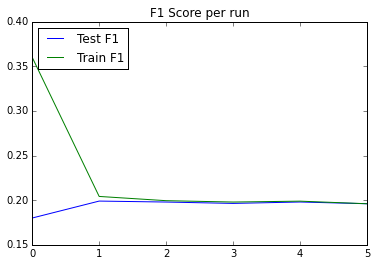

AttributeError: 'AdaBoostClassifier' object has no attribute 'runPredict'

In [80]:
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


In [92]:
prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Validation Prediction for:
 F23- is 0.0829898781069
 F24-26 is 0.0828918102827
 F27-28 is 0.082238417717
 F29-32 is 0.0823158676926
 F33-42 is 0.0820820909312
 F43+ is 0.0823641072158
 M22- is 0.0843289723004
 M23-26 is 0.0851039951313
 M27-28 is 0.0834460452183
 M29-31 is 0.0840755940204
 M32-38 is 0.0842184516947
 M39+ is 0.0839447696887


### EOF